Install required libraies

In [1]:
pip install nlpaug

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 410.5/410.5 kB 11.4 MB/s eta 0:00:00


Import Libraries

In [2]:
import pandas as pd # import all the required libraires
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import re
import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, classification_report
from sklearn.utils.class_weight import compute_class_weight
import nlpaug.augmenter.word as naw
from collections import Counter
import re
import random
import pandas as pd
from collections import Counter
import nltk
from nltk.tokenize import word_tokenize
from nltk.corpus import wordnet, stopwords
from nltk.stem import WordNetLemmatizer

In [3]:
nltk.download('stopwords') # download required nlp kits
nltk.download('punkt')
nltk.download('punkt_tab')
nltk.download('wordnet')
nltk.download('omw-1.4')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package punkt_tab to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt_tab.zip.
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data] Downloading package omw-1.4 to /root/nltk_data...


True

In [4]:
aug = naw.SynonymAug(aug_src='wordnet', aug_min=1, aug_max=3) # synonyms generator

Load dataset

In [5]:
from google.colab import drive # get dataset from drive
drive.mount('/content/drive')

Mounted at /content/drive


In [6]:
df = pd.read_excel('/content/drive/MyDrive/Dataset-1.xlsx', engine='openpyxl') # load excel file
df.head()

,ID,TITLE,ABSTRACT,Computer Science,Physics,Mathematics,Statistics,Quantitative Biology,Quantitative Finance
0,1,Reconstructing Subject-Specific Effect Maps,Predictive models allow subject-specific inf...,1,0,0,0,0,0
1,2,Rotation Invariance Neural Network,Rotation invariance and translation invarian...,1,0,0,0,0,0
2,3,Spherical polyharmonics and Poisson kernels fo...,We introduce and develop the notion of spher...,0,0,1,0,0,0
3,4,A finite element approximation for the stochas...,The stochastic Landau--Lifshitz--Gilbert (LL...,0,0,1,0,0,0
4,5,Comparative study of Discrete Wavelet Transfor...,Fourier-transform infra-red (FTIR) spectra o...,1,0,0,1,0,0


Class Distribution

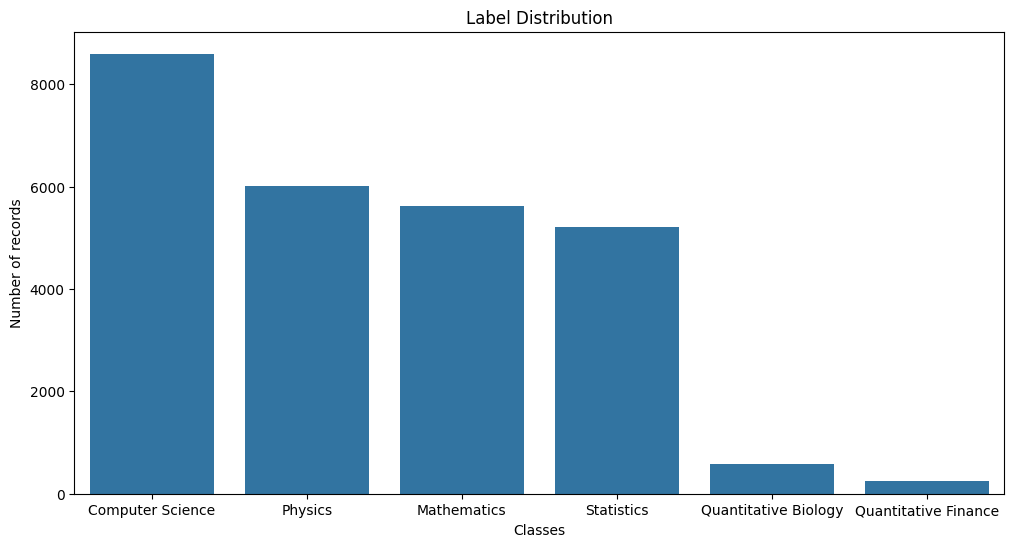

In [7]:
label_columns = df.columns[3:9] # print the distribution of classes
label_distribution = df[label_columns].sum().sort_values(ascending=False)
plt.figure(figsize=(12, 6))
sns.barplot(x=label_distribution.index, y=label_distribution.values)
plt.xlabel("Classes")
plt.ylabel("Number of records")
plt.title("Label Distribution")
plt.show()

From the image, it is clear that a stark class imbalance is present in the dataset.

Data Preprocessing

In [8]:
# Apply to combined TITLE + ABSTRACT
df['TEXT'] = df['TITLE'] + " " +  df['ABSTRACT']
# X = "Title: " + df.iloc[:, 1]+ ", Abstract: " + df.iloc[:,2]
df['LABEL'] = df.iloc[:,3:9].idxmax(axis=1)

In [9]:
df['TEXT'].iloc[0]

"Reconstructing Subject-Specific Effect Maps   Predictive models allow subject-specific inference when analyzing disease\nrelated alterations in neuroimaging data. Given a subject's data, inference can\nbe made at two levels: global, i.e. identifiying condition presence for the\nsubject, and local, i.e. detecting condition effect on each individual\nmeasurement extracted from the subject's data. While global inference is widely\nused, local inference, which can be used to form subject-specific effect maps,\nis rarely used because existing models often yield noisy detections composed of\ndispersed isolated islands. In this article, we propose a reconstruction\nmethod, named RSM, to improve subject-specific detections of predictive\nmodeling approaches and in particular, binary classifiers. RSM specifically\naims to reduce noise due to sampling error associated with using a finite\nsample of examples to train classifiers. The proposed method is a wrapper-type\nalgorithm that can be used 

In [10]:
df['LABEL'].iloc[4]

'Computer Science'

In [11]:
unique_classes, counts = np.unique(df['LABEL'], return_counts=True) # getting class counts
for cls, cnt in zip(unique_classes, counts):
    print(f"Class {cls}: {cnt} samples")

Class Computer Science: 8594 samples
Class Mathematics: 4436 samples
Class Physics: 5521 samples
Class Quantitative Biology: 447 samples
Class Quantitative Finance: 209 samples
Class Statistics: 1765 samples


In [12]:
df.isnull().sum() # check if any null

,0
ID,0
TITLE,0
ABSTRACT,0
Computer Science,0
Physics,0
Mathematics,0
Statistics,0
Quantitative Biology,0
Quantitative Finance,0
TEXT,0


In [13]:
df.shape

(20972, 11)

In [14]:
df.drop_duplicates(inplace = True) # drop all duplicates in the dataset

In [15]:
df.shape

(20972, 11)

In [16]:
def print_num_words(text): # print the number of words
  print(text.apply(lambda x: len(x.split(' '))).sum())
print_num_words(df['TEXT'])

3086457


Text Cleaning

In [17]:
stop_words = set(stopwords.words('english')) # getting stopwords in the english language
lemmatizer = WordNetLemmatizer() # lemmatizer initialized to lemmatoze text

def preprocess_text(text): # function to preprocess text
    if not isinstance(text, str): # checking if text is of type string
        return ""
    text = text.lower() # converting to lower case
    text = re.sub(r'[/(){}\[\]\|@,;]', ' ', text) # remove special characters
    text = re.sub(r'[^a-z\s]', '', text) # keep alphabets
    words = word_tokenize(text) # tokenize text to words
    words = [lemmatizer.lemmatize(w) for w in words if w not in stop_words] # lemmatize text and remove stopwords
    return ' '.join(words) # join the tokens back to text

# Apply cleaning of data
df['TEXT'] = df['TEXT'].apply(preprocess_text)

Synonym Replacement for Augmentation

In [18]:
def get_synonyms(word): # get synpnyms for a given word
    synonyms = set()
    for syn in wordnet.synsets(word):
        for lemma in syn.lemmas():
            w = lemma.name().replace('_', ' ').lower()
            if w != word.lower():
                synonyms.add(w)
    return list(synonyms)

def synonym_augment(text, n_replacements=2): # augment the dataset using the synonyms
    words = word_tokenize(text)
    new_words = words.copy()
    eligible_indices = [i for i, word in enumerate(words) if wordnet.synsets(word)]

    if not eligible_indices:
        return text  # no replaceable words

    random.shuffle(eligible_indices)
    replaced = 0

    for idx in eligible_indices:
        synonyms = get_synonyms(words[idx])
        if synonyms:
            new_words[idx] = random.choice(synonyms)
            replaced += 1
        if replaced >= n_replacements:
            break

    return ' '.join(new_words)

# augment only the minority classes
augmented_texts = []
augmented_labels = []

label_counts = Counter(df['LABEL'])
majority_count = max(label_counts.values())

minority_classes = [cls for cls, count in label_counts.items() if count < 0.5 * majority_count] # set a threshold

print("Minority classes detected for augmentation:", minority_classes)

for cls in minority_classes:
    samples = df[df['LABEL'] == cls]

    for _, row in samples.iterrows():
        for _ in range(3):  # 3 augmentations per original
            try:
                aug_text = synonym_augment(row['TEXT'], n_replacements=2)
                # optionally skip empty augmentations
                if aug_text.strip():
                    augmented_texts.append(aug_text)
                    augmented_labels.append(cls)
            except Exception as e:
                continue


# merge augmented and original data
df_aug = pd.DataFrame({'TEXT': augmented_texts, 'LABEL': augmented_labels})
df_combined = pd.concat([df, df_aug], ignore_index=True).drop_duplicates().reset_index(drop=True)

print("Original size:", len(df))
print("Augmented size:", len(df_aug))
print("Combined size:", len(df_combined))


Minority classes detected for augmentation: ['Quantitative Biology', 'Statistics', 'Quantitative Finance']
Original size: 20972
Augmented size: 7263
Combined size: 28235


Vectorizer

In [20]:
from sklearn.feature_extraction.text import TfidfVectorizer # vectorize text using tfidf vectorizer

vectorizer = TfidfVectorizer(max_features=10000)
X = vectorizer.fit_transform(df_combined['TEXT'])
y = df_combined['LABEL']


Label Encoder

In [21]:
from sklearn.preprocessing import LabelEncoder # label encode the label column

le = LabelEncoder()
y = le.fit_transform(df_combined['LABEL'])


Dimension reduction and Train-test split

In [22]:
from sklearn.decomposition import TruncatedSVD

svd = TruncatedSVD(n_components=300)  # reduce feature dimensionality
X_reduced = svd.fit_transform(X)  # transform full dataset

# train-test split
X_train, X_test, y_train, y_test = train_test_split(X_reduced, y, shuffle=True, test_size=0.2, random_state=42)

In [24]:
# import warnings
# from sklearn.exceptions import ConvergenceWarning

# # Suppress only convergence warnings
# warnings.filterwarnings("ignore", category=ConvergenceWarning)

**Machine Learing models**

Logistic Regression

Epoch 1/200 - Log Loss: 1.6280
Epoch 2/200 - Log Loss: 1.5783
Epoch 3/200 - Log Loss: 1.5732
Epoch 4/200 - Log Loss: 1.5634
Epoch 5/200 - Log Loss: 1.5572
Epoch 6/200 - Log Loss: 1.5214
Epoch 7/200 - Log Loss: 1.4914
Epoch 8/200 - Log Loss: 1.4816
Epoch 9/200 - Log Loss: 1.4730
Epoch 10/200 - Log Loss: 1.4652
Epoch 11/200 - Log Loss: 1.4576
Epoch 12/200 - Log Loss: 1.4501
Epoch 13/200 - Log Loss: 1.4428
Epoch 14/200 - Log Loss: 1.4355
Epoch 15/200 - Log Loss: 1.4285
Epoch 16/200 - Log Loss: 1.4214
Epoch 17/200 - Log Loss: 1.4145
Epoch 18/200 - Log Loss: 1.4076
Epoch 19/200 - Log Loss: 1.4009
Epoch 20/200 - Log Loss: 1.3942
Epoch 21/200 - Log Loss: 1.3876
Epoch 22/200 - Log Loss: 1.3811
Epoch 23/200 - Log Loss: 1.3746
Epoch 24/200 - Log Loss: 1.3682
Epoch 25/200 - Log Loss: 1.3620
Epoch 26/200 - Log Loss: 1.3557
Epoch 27/200 - Log Loss: 1.3495
Epoch 28/200 - Log Loss: 1.3434
Epoch 29/200 - Log Loss: 1.3373
Epoch 30/200 - Log Loss: 1.3313
Epoch 31/200 - Log Loss: 1.3253
Epoch 32/200 - Lo

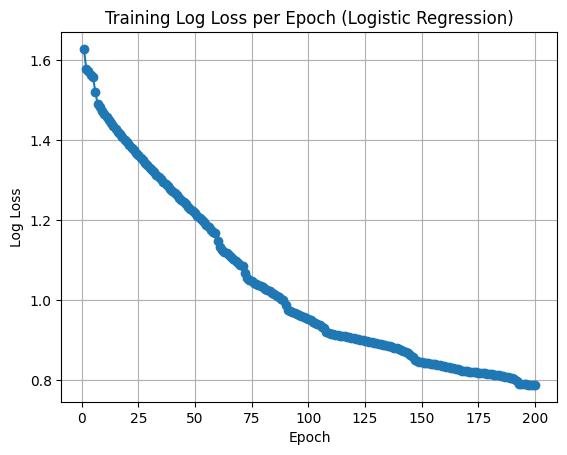

In [25]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import log_loss
from sklearn.preprocessing import StandardScaler

# initialize model with warm_start=True so we can fit multiple times
model = LogisticRegression(
    penalty='l2',            # L2 regularization for better generalization
    C=1.0,                   # inverse of regularization strength; smaller values mean stronger regularization
    max_iter=1,              # 1 iteration per fit call (for manual epoch control)
    warm_start=True,         # retain previous state for incremental training
    solver='lbfgs',          # good default solver for small to medium datasets
    tol=1e-4,                # stopping tolerance for optimization; smaller for more precision
    verbose=0,
    random_state=42,
    fit_intercept=True       # fit the intercept term
)


train_losses = []
n_epochs = 200

for epoch in range(n_epochs):
    model.fit(X_train, y_train)  # fits 1 iteration at a time
    # predict probabilities to compute log loss
    probs = model.predict_proba(X_train)
    loss = log_loss(y_train, probs)
    train_losses.append(loss)
    print(f"Epoch {epoch+1}/{n_epochs} - Log Loss: {loss:.4f}")

# plot training loss curve
plt.plot(range(1, n_epochs + 1), train_losses, marker='o')
plt.xlabel('Epoch')
plt.ylabel('Log Loss')
plt.title('Training Log Loss per Epoch (Logistic Regression)')
plt.grid(True)
plt.show()


In [26]:
# print classification report of logistic regression
y_pred = model.predict(X_test)
print("\nClassification Report:")
print(classification_report(y_test, y_pred))


Classification Report:
              precision    recall  f1-score   support

           0       0.64      0.75      0.69      1714
           1       0.82      0.75      0.78       905
           2       0.85      0.86      0.85      1085
           3       0.72      0.35      0.47       376
           4       0.87      0.45      0.59       181
           5       0.62      0.64      0.63      1386

    accuracy                           0.71      5647
   macro avg       0.75      0.63      0.67      5647
weighted avg       0.72      0.71      0.70      5647



Support Vector Machine

In [27]:
from sklearn.svm import SVC
from sklearn.metrics import hinge_loss


model = SVC(
    kernel='rbf',       # radial basis function kernel
    C=1.0,              # regularization parameter
    gamma='scale',      # kernel coefficient
    probability=True,   # enable probability estimates
    class_weight='balanced',  # handle class imbalance automatically
    random_state=42
)

# fit
model.fit(X_train, y_train)

# decision_function returns raw margin distances
decision_scores = model.decision_function(X_train)

loss = hinge_loss(y_train, decision_scores)
print("Final Hinge Loss:", loss)

Final Hinge Loss: 0.188386302368625


In [28]:
from sklearn.metrics import classification_report

# predict the labels
y_pred = model.predict(X_test)
# print classification report
report = classification_report(y_test, y_pred)
print(report)


              precision    recall  f1-score   support

           0       0.87      0.75      0.81      1714
           1       0.82      0.83      0.82       905
           2       0.92      0.88      0.90      1085
           3       0.86      0.98      0.92       376
           4       0.90      1.00      0.95       181
           5       0.81      0.91      0.86      1386

    accuracy                           0.85      5647
   macro avg       0.86      0.89      0.88      5647
weighted avg       0.86      0.85      0.85      5647



Random Forest

Trees: 1, OOB Error: 0.5707
Trees: 2, OOB Error: 0.4985
Trees: 3, OOB Error: 0.4353
Trees: 4, OOB Error: 0.3924
Trees: 5, OOB Error: 0.3574
Trees: 6, OOB Error: 0.3322
Trees: 7, OOB Error: 0.3131
Trees: 8, OOB Error: 0.2945
Trees: 9, OOB Error: 0.2782
Trees: 10, OOB Error: 0.2653
Trees: 11, OOB Error: 0.2523
Trees: 12, OOB Error: 0.2427
Trees: 13, OOB Error: 0.2342
Trees: 14, OOB Error: 0.2253
Trees: 15, OOB Error: 0.2160
Trees: 16, OOB Error: 0.2101
Trees: 17, OOB Error: 0.2045
Trees: 18, OOB Error: 0.1981
Trees: 19, OOB Error: 0.1921
Trees: 20, OOB Error: 0.1879
Trees: 21, OOB Error: 0.1815
Trees: 22, OOB Error: 0.1789
Trees: 23, OOB Error: 0.1764
Trees: 24, OOB Error: 0.1723
Trees: 25, OOB Error: 0.1699
Trees: 26, OOB Error: 0.1669
Trees: 27, OOB Error: 0.1642
Trees: 28, OOB Error: 0.1625
Trees: 29, OOB Error: 0.1609
Trees: 30, OOB Error: 0.1600
Trees: 31, OOB Error: 0.1582
Trees: 32, OOB Error: 0.1574
Trees: 33, OOB Error: 0.1544
Trees: 34, OOB Error: 0.1526
Trees: 35, OOB Error: 0

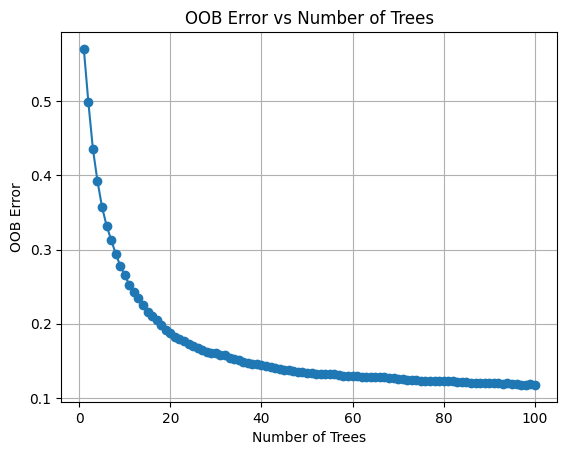

In [29]:
import matplotlib.pyplot as plt
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score
import numpy as np
import warnings

warnings.filterwarnings("ignore", category=UserWarning)

oob_errors = []
n_trees = 100

# initialize model with warm_start and oob_score enabled
model = RandomForestClassifier(
    n_estimators=1,
    oob_score=True,
    warm_start=True,
    max_depth=20,
    max_features='sqrt',
    class_weight='balanced_subsample',
    n_jobs=-1,
    random_state=42
)

# incrementally add trees
for i in range(1, n_trees + 1):
    model.n_estimators = i
    model.fit(X_train, y_train)

    oob_error = 1 - model.oob_score_
    oob_errors.append(oob_error)
    print(f"Trees: {i}, OOB Error: {oob_error:.4f}")

# plot OOB error
plt.plot(range(1, n_trees + 1), oob_errors, marker='o')
plt.xlabel("Number of Trees")
plt.ylabel("OOB Error")
plt.title("OOB Error vs Number of Trees")
plt.grid(True)
plt.show()


In [30]:
from sklearn.metrics import classification_report

# predict the labels
y_pred = model.predict(X_test)

# print classification report
report = classification_report(y_test, y_pred)
print(report)


              precision    recall  f1-score   support

           0       0.84      0.91      0.87      1714
           1       0.85      0.74      0.79       905
           2       0.93      0.83      0.88      1085
           3       0.96      0.94      0.95       376
           4       0.97      0.99      0.98       181
           5       0.93      0.99      0.96      1386

    accuracy                           0.89      5647
   macro avg       0.91      0.90      0.91      5647
weighted avg       0.89      0.89      0.89      5647



XG Boost

[0]	validation_0-mlogloss:1.64085
[1]	validation_0-mlogloss:1.51589
[2]	validation_0-mlogloss:1.41078
[3]	validation_0-mlogloss:1.32069
[4]	validation_0-mlogloss:1.24266
[5]	validation_0-mlogloss:1.17089
[6]	validation_0-mlogloss:1.10745
[7]	validation_0-mlogloss:1.05049
[8]	validation_0-mlogloss:0.99717
[9]	validation_0-mlogloss:0.94969
[10]	validation_0-mlogloss:0.90609
[11]	validation_0-mlogloss:0.86607
[12]	validation_0-mlogloss:0.83014
[13]	validation_0-mlogloss:0.79573
[14]	validation_0-mlogloss:0.76433
[15]	validation_0-mlogloss:0.73476
[16]	validation_0-mlogloss:0.70680
[17]	validation_0-mlogloss:0.68143
[18]	validation_0-mlogloss:0.65827
[19]	validation_0-mlogloss:0.63629
[20]	validation_0-mlogloss:0.61457
[21]	validation_0-mlogloss:0.59517
[22]	validation_0-mlogloss:0.57645
[23]	validation_0-mlogloss:0.55884
[24]	validation_0-mlogloss:0.54203
[25]	validation_0-mlogloss:0.52635
[26]	validation_0-mlogloss:0.51129
[27]	validation_0-mlogloss:0.49708
[28]	validation_0-mlogloss:0.4

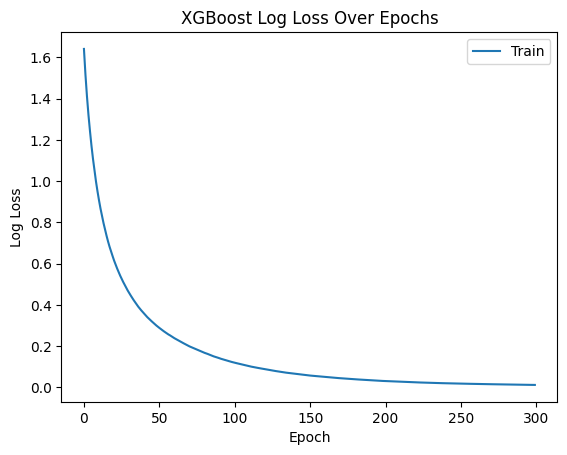

In [31]:
import matplotlib.pyplot as plt
from xgboost import XGBClassifier
from sklearn.utils.class_weight import compute_sample_weight

# compute sample weights for imbalance
sample_weights = compute_sample_weight(class_weight='balanced', y=y_train)

# prepare eval sets for monitoring
eval_set = [(X_train, y_train)]

# model = XGBClassifier(use_label_encoder=False, eval_metric='mlogloss', verbosity=1, n_estimators=20)
model = XGBClassifier(
    n_estimators=300,
    learning_rate=0.1,
    max_depth=7,
    subsample=0.9,
    colsample_bytree=0.9,
    objective='multi:softprob',
    eval_metric='mlogloss',
    use_label_encoder=False,
    verbosity=1,
    n_jobs = -1
)

# fit with eval_set to track metrics
model.fit(X_train, y_train, sample_weight=sample_weights, eval_set=eval_set, verbose=True)

# retrieve eval results
results = model.evals_result()

# plot training logloss
epochs = len(results['validation_0']['mlogloss'])
x_axis = range(0, epochs)

plt.plot(x_axis, results['validation_0']['mlogloss'], label='Train')

plt.xlabel('Epoch')
plt.ylabel('Log Loss')
plt.title('XGBoost Log Loss Over Epochs')
plt.legend()
plt.show()


In [32]:
from sklearn.metrics import classification_report

y_pred = model.predict(X_test)
print(classification_report(y_test, y_pred)) # print classification report

              precision    recall  f1-score   support

           0       0.89      0.86      0.88      1714
           1       0.85      0.81      0.83       905
           2       0.92      0.88      0.90      1085
           3       0.94      0.97      0.95       376
           4       0.97      1.00      0.99       181
           5       0.90      1.00      0.95      1386

    accuracy                           0.90      5647
   macro avg       0.91      0.92      0.92      5647
weighted avg       0.90      0.90      0.90      5647



**Deep Learning Models**

In [33]:
num_classes = 7

In [34]:
train_losses = { 'MLP': [], 'RNN': [], 'LSTM': [], 'GRU': [], 'BiRNN': [], 'BiLSTM': [], 'BiGRU': [], 'CNN': []}

MLP

In [35]:
import torch
from torch import nn
import torch.optim as optim

import torch

X_train_tensor = torch.tensor(X_train, dtype=torch.float32) # convert data to tensor
X_test_tensor = torch.tensor(X_test, dtype=torch.float32)
y_train_tensor = torch.tensor(y_train, dtype=torch.long)
y_test_tensor = torch.tensor(y_test, dtype=torch.long)

class SimpleMLP(nn.Module): # define a simple MLP with 1 hidden layer
    def __init__(self, input_dim, hidden_dim, output_dim):
        super(SimpleMLP, self).__init__()
        self.fc1 = nn.Linear(input_dim, hidden_dim)
        self.relu = nn.ReLU()
        self.fc2 = nn.Linear(hidden_dim, output_dim)

    def forward(self, x):
        out = self.fc1(x)
        out = self.relu(out)
        out = self.fc2(out)
        return out

input_dim = X_train.shape[1]
hidden_dim = 16
output_dim = len(np.unique(y))  # number of classes

model = SimpleMLP(input_dim, hidden_dim, output_dim)

# loss and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.01)

# training loop
num_epochs = 300
for epoch in range(num_epochs):
    model.train()
    optimizer.zero_grad()

    outputs = model(X_train_tensor)
    loss = criterion(outputs, y_train_tensor)

    loss.backward()
    optimizer.step()

    train_losses['MLP'].append(loss.item())

    if (epoch+1) % 10 == 0 or epoch == 0:
        print(f'Epoch [{epoch+1}/{num_epochs}], Loss: {loss.item():.4f}')

# evaluate on test set
model.eval()
with torch.no_grad():
    test_outputs = model(X_test_tensor)
    _, predicted = torch.max(test_outputs, 1)
    print("\nClassification Report:")
    print(classification_report(y_test, predicted))

Epoch [1/300], Loss: 1.8215
Epoch [10/300], Loss: 1.6811
Epoch [20/300], Loss: 1.4887
Epoch [30/300], Loss: 1.3597
Epoch [40/300], Loss: 1.2262
Epoch [50/300], Loss: 1.0886
Epoch [60/300], Loss: 0.9594
Epoch [70/300], Loss: 0.8509
Epoch [80/300], Loss: 0.7699
Epoch [90/300], Loss: 0.7130
Epoch [100/300], Loss: 0.6721
Epoch [110/300], Loss: 0.6419
Epoch [120/300], Loss: 0.6190
Epoch [130/300], Loss: 0.6009
Epoch [140/300], Loss: 0.5858
Epoch [150/300], Loss: 0.5723
Epoch [160/300], Loss: 0.5599
Epoch [170/300], Loss: 0.5484
Epoch [180/300], Loss: 0.5376
Epoch [190/300], Loss: 0.5274
Epoch [200/300], Loss: 0.5175
Epoch [210/300], Loss: 0.5077
Epoch [220/300], Loss: 0.4979
Epoch [230/300], Loss: 0.4881
Epoch [240/300], Loss: 0.4787
Epoch [250/300], Loss: 0.4698
Epoch [260/300], Loss: 0.4610
Epoch [270/300], Loss: 0.4525
Epoch [280/300], Loss: 0.4441
Epoch [290/300], Loss: 0.4359
Epoch [300/300], Loss: 0.4280

Classification Report:
              precision    recall  f1-score   support

  

RNN

In [36]:
import torch
from torch import nn
import torch.optim as optim

# convert data to PyTorch tensors
X_train_tensor = torch.tensor(X_train, dtype=torch.float32)
X_test_tensor = torch.tensor(X_test, dtype=torch.float32)
y_train_tensor = torch.tensor(y_train, dtype=torch.long)
y_test_tensor = torch.tensor(y_test, dtype=torch.long)

# define a simple RNN model
class SimpleRNN(nn.Module):
    def __init__(self, input_dim, hidden_dim, output_dim, num_layers=1):
        super(SimpleRNN, self).__init__()
        self.rnn = nn.RNN(input_dim, hidden_dim, num_layers=num_layers, batch_first=True)
        self.fc = nn.Linear(hidden_dim, output_dim)

    def forward(self, x):
        x = x.unsqueeze(1)  # add sequence dimension (batch_first=True expects [batch, seq_len, input_size])
        out, _ = self.rnn(x)
        out = out[:, -1, :]  # take the last hidden state
        out = self.fc(out)
        return out

# model hyperparameters
input_dim = X_train.shape[1]
hidden_dim = 32
output_dim = len(np.unique(y))  # number of classes
num_layers = 1

model = SimpleRNN(input_dim, hidden_dim, output_dim, num_layers)

# loss and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.01)

# training loop
num_epochs = 300
for epoch in range(num_epochs):
    model.train()
    optimizer.zero_grad()

    outputs = model(X_train_tensor)
    loss = criterion(outputs, y_train_tensor)

    loss.backward()
    optimizer.step()

    train_losses['RNN'].append(loss.item())

    if (epoch+1) % 10 == 0 or epoch == 0:
        print(f"Epoch [{epoch+1}/{num_epochs}], Loss: {loss.item():.4f}")

# evaluate on test set
model.eval()
with torch.no_grad():
    test_outputs = model(X_test_tensor)
    _, predicted = torch.max(test_outputs, 1)
    print("\nClassification Report:")
    print(classification_report(y_test, predicted))


Epoch [1/300], Loss: 1.8198
Epoch [10/300], Loss: 1.5397
Epoch [20/300], Loss: 1.4032
Epoch [30/300], Loss: 1.2073
Epoch [40/300], Loss: 1.0135
Epoch [50/300], Loss: 0.8520
Epoch [60/300], Loss: 0.7443
Epoch [70/300], Loss: 0.6824
Epoch [80/300], Loss: 0.6477
Epoch [90/300], Loss: 0.6272
Epoch [100/300], Loss: 0.6138
Epoch [110/300], Loss: 0.6038
Epoch [120/300], Loss: 0.5953
Epoch [130/300], Loss: 0.5872
Epoch [140/300], Loss: 0.5790
Epoch [150/300], Loss: 0.5700
Epoch [160/300], Loss: 0.5599
Epoch [170/300], Loss: 0.5486
Epoch [180/300], Loss: 0.5359
Epoch [190/300], Loss: 0.5219
Epoch [200/300], Loss: 0.5066
Epoch [210/300], Loss: 0.4900
Epoch [220/300], Loss: 0.4724
Epoch [230/300], Loss: 0.4540
Epoch [240/300], Loss: 0.4353
Epoch [250/300], Loss: 0.4163
Epoch [260/300], Loss: 0.3975
Epoch [270/300], Loss: 0.3791
Epoch [280/300], Loss: 0.3612
Epoch [290/300], Loss: 0.3440
Epoch [300/300], Loss: 0.3275

Classification Report:
              precision    recall  f1-score   support

  

LSTM

In [37]:
import torch
from torch import nn
import torch.optim as optim

# convert data to PyTorch tensors
X_train_tensor = torch.tensor(X_train, dtype=torch.float32)
X_test_tensor = torch.tensor(X_test, dtype=torch.float32)
y_train_tensor = torch.tensor(y_train, dtype=torch.long)
y_test_tensor = torch.tensor(y_test, dtype=torch.long)

# define LSTM Model
class SimpleLSTM(nn.Module):
    def __init__(self, input_dim, hidden_dim, output_dim, num_layers=1):
        super(SimpleLSTM, self).__init__()
        self.lstm = nn.LSTM(input_dim, hidden_dim, num_layers=num_layers, batch_first=True)
        self.fc = nn.Linear(hidden_dim, output_dim)

    def forward(self, x):
        x = x.unsqueeze(1)  # add sequence dimension
        out, _ = self.lstm(x)
        out = out[:, -1, :]  # take the last hidden state
        out = self.fc(out)
        return out

# model hyperparameters
input_dim = X_train.shape[1]
hidden_dim = 64
output_dim = len(np.unique(y))  # number of classes
num_layers = 2  # using 2-layer LSTM for better representation

model = SimpleLSTM(input_dim, hidden_dim, output_dim, num_layers)

# loss and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.01)

# training loop
num_epochs = 300
for epoch in range(num_epochs):
    model.train()
    optimizer.zero_grad()

    outputs = model(X_train_tensor)
    loss = criterion(outputs, y_train_tensor)

    loss.backward()
    optimizer.step()

    train_losses['LSTM'].append(loss.item())

    if (epoch+1) % 10 == 0 or epoch == 0:
        print(f'Epoch [{epoch+1}/{num_epochs}], Loss: {loss.item():.4f}')

# evaluate on test set
model.eval()
with torch.no_grad():
    test_outputs = model(X_test_tensor)
    _, predicted = torch.max(test_outputs, 1)
    print("\nClassification Report:")
    print(classification_report(y_test, predicted))


Epoch [1/300], Loss: 1.7874
Epoch [10/300], Loss: 1.5796
Epoch [20/300], Loss: 1.4863
Epoch [30/300], Loss: 1.2230
Epoch [40/300], Loss: 0.8750
Epoch [50/300], Loss: 0.7313
Epoch [60/300], Loss: 0.6522
Epoch [70/300], Loss: 0.6047
Epoch [80/300], Loss: 0.5680
Epoch [90/300], Loss: 0.5284
Epoch [100/300], Loss: 0.4866
Epoch [110/300], Loss: 0.4384
Epoch [120/300], Loss: 0.3826
Epoch [130/300], Loss: 0.3170
Epoch [140/300], Loss: 0.2492
Epoch [150/300], Loss: 0.1871
Epoch [160/300], Loss: 0.1342
Epoch [170/300], Loss: 0.0930
Epoch [180/300], Loss: 0.0638
Epoch [190/300], Loss: 0.0440
Epoch [200/300], Loss: 0.0307
Epoch [210/300], Loss: 0.0218
Epoch [220/300], Loss: 0.0158
Epoch [230/300], Loss: 0.0118
Epoch [240/300], Loss: 0.0090
Epoch [250/300], Loss: 0.0071
Epoch [260/300], Loss: 0.0057
Epoch [270/300], Loss: 0.0047
Epoch [280/300], Loss: 0.0040
Epoch [290/300], Loss: 0.0034
Epoch [300/300], Loss: 0.0030

Classification Report:
              precision    recall  f1-score   support

  

GRU

In [38]:
import torch
from torch import nn
import torch.optim as optim

# convert data to PyTorch tensors
X_train_tensor = torch.tensor(X_train, dtype=torch.float32)
X_test_tensor = torch.tensor(X_test, dtype=torch.float32)
y_train_tensor = torch.tensor(y_train, dtype=torch.long)
y_test_tensor = torch.tensor(y_test, dtype=torch.long)

# define GRU Model
class SimpleGRU(nn.Module):
    def __init__(self, input_dim, hidden_dim, output_dim, num_layers=1):
        super(SimpleGRU, self).__init__()
        self.gru = nn.GRU(input_dim, hidden_dim, num_layers=num_layers, batch_first=True)
        self.fc = nn.Linear(hidden_dim, output_dim)

    def forward(self, x):
        x = x.unsqueeze(1)  # add sequence dimension
        out, _ = self.gru(x)
        out = out[:, -1, :]  # take the last hidden state
        out = self.fc(out)
        return out

# model hyperparameters
input_dim = X_train.shape[1]
hidden_dim = 64  # increased for richer feature extraction
output_dim = len(np.unique(y))  # number of classes
num_layers = 2  # using 2-layer GRU

model = SimpleGRU(input_dim, hidden_dim, output_dim, num_layers)

# loss and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.01)

# training loop
num_epochs = 300
for epoch in range(num_epochs):
    model.train()
    optimizer.zero_grad()

    outputs = model(X_train_tensor)
    loss = criterion(outputs, y_train_tensor)

    loss.backward()
    optimizer.step()

    train_losses['GRU'].append(loss.item())

    if (epoch+1) % 10 == 0 or epoch == 0:
        print(f'Epoch [{epoch+1}/{num_epochs}], Loss: {loss.item():.4f}')

# evaluate on test set
model.eval()
with torch.no_grad():
    test_outputs = model(X_test_tensor)
    _, predicted = torch.max(test_outputs, 1)
    print("\nClassification Report:")
    print(classification_report(y_test, predicted))


Epoch [1/300], Loss: 1.8040
Epoch [10/300], Loss: 1.5565
Epoch [20/300], Loss: 1.2900
Epoch [30/300], Loss: 0.8632
Epoch [40/300], Loss: 0.6933
Epoch [50/300], Loss: 0.6303
Epoch [60/300], Loss: 0.5902
Epoch [70/300], Loss: 0.5620
Epoch [80/300], Loss: 0.5379
Epoch [90/300], Loss: 0.5126
Epoch [100/300], Loss: 0.4816
Epoch [110/300], Loss: 0.4393
Epoch [120/300], Loss: 0.3873
Epoch [130/300], Loss: 0.3279
Epoch [140/300], Loss: 0.2655
Epoch [150/300], Loss: 0.2043
Epoch [160/300], Loss: 0.1518
Epoch [170/300], Loss: 0.1099
Epoch [180/300], Loss: 0.0785
Epoch [190/300], Loss: 0.0556
Epoch [200/300], Loss: 0.0390
Epoch [210/300], Loss: 0.0269
Epoch [220/300], Loss: 0.0185
Epoch [230/300], Loss: 0.0130
Epoch [240/300], Loss: 0.0094
Epoch [250/300], Loss: 0.0070
Epoch [260/300], Loss: 0.0054
Epoch [270/300], Loss: 0.0044
Epoch [280/300], Loss: 0.0036
Epoch [290/300], Loss: 0.0031
Epoch [300/300], Loss: 0.0026

Classification Report:
              precision    recall  f1-score   support

  

Bidrectional RNN

In [39]:
import torch
from torch import nn
import torch.optim as optim

# convert data to PyTorch tensors
X_train_tensor = torch.tensor(X_train, dtype=torch.float32)
X_test_tensor = torch.tensor(X_test, dtype=torch.float32)
y_train_tensor = torch.tensor(y_train, dtype=torch.long)
y_test_tensor = torch.tensor(y_test, dtype=torch.long)

# define Bidirectional RNN Model
class BiRNN(nn.Module):
    def __init__(self, input_dim, hidden_dim, output_dim, num_layers=1):
        super(BiRNN, self).__init__()
        self.rnn = nn.RNN(input_dim, hidden_dim, num_layers=num_layers, batch_first=True, bidirectional=True)
        self.fc = nn.Linear(hidden_dim * 2, output_dim)  # multiply by 2 for bidirectional output

    def forward(self, x):
        x = x.unsqueeze(1)  # add sequence dimension
        out, _ = self.rnn(x)
        out = out[:, -1, :]  # take the last hidden state
        out = self.fc(out)
        return out

# model hyperparameters
input_dim = X_train.shape[1]
hidden_dim = 64  # increased for richer feature extraction
output_dim = len(np.unique(y))  # number of classes
num_layers = 2  # using 2-layer bidirectional RNN

model = BiRNN(input_dim, hidden_dim, output_dim, num_layers)

# loss and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.01)

# training loop
num_epochs = 300
for epoch in range(num_epochs):
    model.train()
    optimizer.zero_grad()

    outputs = model(X_train_tensor)
    loss = criterion(outputs, y_train_tensor)

    loss.backward()
    optimizer.step()

    train_losses['BiRNN'].append(loss.item())

    if (epoch+1) % 10 == 0 or epoch == 0:
        print(f'Epoch [{epoch+1}/{num_epochs}], Loss: {loss.item():.4f}')

# evaluate on test set
model.eval()
with torch.no_grad():
    test_outputs = model(X_test_tensor)
    _, predicted = torch.max(test_outputs, 1)
    print("\nClassification Report:")
    print(classification_report(y_test, predicted))


Epoch [1/300], Loss: 1.7733
Epoch [10/300], Loss: 1.1884
Epoch [20/300], Loss: 0.6939
Epoch [30/300], Loss: 0.6402
Epoch [40/300], Loss: 0.6004
Epoch [50/300], Loss: 0.5836
Epoch [60/300], Loss: 0.5725
Epoch [70/300], Loss: 0.5618
Epoch [80/300], Loss: 0.5491
Epoch [90/300], Loss: 0.5326
Epoch [100/300], Loss: 0.5130
Epoch [110/300], Loss: 0.4912
Epoch [120/300], Loss: 0.4659
Epoch [130/300], Loss: 0.4366
Epoch [140/300], Loss: 0.4039
Epoch [150/300], Loss: 0.3690
Epoch [160/300], Loss: 0.3346
Epoch [170/300], Loss: 0.3001
Epoch [180/300], Loss: 0.2655
Epoch [190/300], Loss: 0.2314
Epoch [200/300], Loss: 0.1983
Epoch [210/300], Loss: 0.1675
Epoch [220/300], Loss: 0.1393
Epoch [230/300], Loss: 0.1143
Epoch [240/300], Loss: 0.0924
Epoch [250/300], Loss: 0.0739
Epoch [260/300], Loss: 0.0587
Epoch [270/300], Loss: 0.0465
Epoch [280/300], Loss: 0.0370
Epoch [290/300], Loss: 0.0297
Epoch [300/300], Loss: 0.0242

Classification Report:
              precision    recall  f1-score   support

  

Bidrectional LSTM

In [40]:
import torch
from torch import nn
import torch.optim as optim

# convert data to PyTorch tensors
X_train_tensor = torch.tensor(X_train, dtype=torch.float32)
X_test_tensor = torch.tensor(X_test, dtype=torch.float32)
y_train_tensor = torch.tensor(y_train, dtype=torch.long)
y_test_tensor = torch.tensor(y_test, dtype=torch.long)

# define Bidirectional LSTM Model
class BiLSTM(nn.Module):
    def __init__(self, input_dim, hidden_dim, output_dim, num_layers=1):
        super(BiLSTM, self).__init__()
        self.lstm = nn.LSTM(input_dim, hidden_dim, num_layers=num_layers, batch_first=True, bidirectional=True)
        self.fc = nn.Linear(hidden_dim * 2, output_dim)  # multiply by 2 for bidirectional output

    def forward(self, x):
        x = x.unsqueeze(1)  # add sequence dimension
        out, _ = self.lstm(x)
        out = out[:, -1, :]  # take the last hidden state
        out = self.fc(out)
        return out

# model hyperparameters
input_dim = X_train.shape[1]
hidden_dim = 64  # increased for richer feature extraction
output_dim = len(np.unique(y))  # number of classes
num_layers = 2  # using 2-layer bidirectional LSTM

model = BiLSTM(input_dim, hidden_dim, output_dim, num_layers)

# loss and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.01)

# training loop
num_epochs = 300
for epoch in range(num_epochs):
    model.train()
    optimizer.zero_grad()

    outputs = model(X_train_tensor)
    loss = criterion(outputs, y_train_tensor)

    loss.backward()
    optimizer.step()

    train_losses['BiLSTM'].append(loss.item())

    if (epoch+1) % 10 == 0 or epoch == 0:
        print(f'Epoch [{epoch+1}/{num_epochs}], Loss: {loss.item():.4f}')

# evaluate on test set
model.eval()
with torch.no_grad():
    test_outputs = model(X_test_tensor)
    _, predicted = torch.max(test_outputs, 1)
    print("\nClassification Report:")
    print(classification_report(y_test, predicted))


Epoch [1/300], Loss: 1.7703
Epoch [10/300], Loss: 1.5642
Epoch [20/300], Loss: 1.2878
Epoch [30/300], Loss: 0.8260
Epoch [40/300], Loss: 0.6926
Epoch [50/300], Loss: 0.6077
Epoch [60/300], Loss: 0.5599
Epoch [70/300], Loss: 0.5218
Epoch [80/300], Loss: 0.4819
Epoch [90/300], Loss: 0.4321
Epoch [100/300], Loss: 0.3632
Epoch [110/300], Loss: 0.2916
Epoch [120/300], Loss: 0.2052
Epoch [130/300], Loss: 0.1378
Epoch [140/300], Loss: 0.0870
Epoch [150/300], Loss: 0.0530
Epoch [160/300], Loss: 0.0315
Epoch [170/300], Loss: 0.0187
Epoch [180/300], Loss: 0.0115
Epoch [190/300], Loss: 0.0075
Epoch [200/300], Loss: 0.0053
Epoch [210/300], Loss: 0.0039
Epoch [220/300], Loss: 0.0031
Epoch [230/300], Loss: 0.0025
Epoch [240/300], Loss: 0.0020
Epoch [250/300], Loss: 0.0017
Epoch [260/300], Loss: 0.0015
Epoch [270/300], Loss: 0.0013
Epoch [280/300], Loss: 0.0012
Epoch [290/300], Loss: 0.0011
Epoch [300/300], Loss: 0.0010

Classification Report:
              precision    recall  f1-score   support

  

Bidirectional GRU

In [41]:
import torch
from torch import nn
import torch.optim as optim

# convert data to PyTorch tensors
X_train_tensor = torch.tensor(X_train, dtype=torch.float32)
X_test_tensor = torch.tensor(X_test, dtype=torch.float32)
y_train_tensor = torch.tensor(y_train, dtype=torch.long)
y_test_tensor = torch.tensor(y_test, dtype=torch.long)

# define Bidirectional GRU Model
class BiGRU(nn.Module):
    def __init__(self, input_dim, hidden_dim, output_dim, num_layers=1):
        super(BiGRU, self).__init__()
        self.gru = nn.GRU(input_dim, hidden_dim, num_layers=num_layers, batch_first=True, bidirectional=True)
        self.fc = nn.Linear(hidden_dim * 2, output_dim)  # multiply by 2 for bidirectional output

    def forward(self, x):
        x = x.unsqueeze(1)  # add sequence dimension
        out, _ = self.gru(x)
        out = out[:, -1, :]  # take the last hidden state
        out = self.fc(out)
        return out

# model hyperparameters
input_dim = X_train.shape[1]
hidden_dim = 64  # increased for richer feature extraction
output_dim = len(np.unique(y))  # number of classes
num_layers = 2  # using 2-layer bidirectional GRU

model = BiGRU(input_dim, hidden_dim, output_dim, num_layers)

# loss and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.01)

# training loop
num_epochs = 300
for epoch in range(num_epochs):
    model.train()
    optimizer.zero_grad()

    outputs = model(X_train_tensor)
    loss = criterion(outputs, y_train_tensor)

    loss.backward()
    optimizer.step()

    train_losses['BiGRU'].append(loss.item())

    if (epoch+1) % 10 == 0 or epoch == 0:
        print(f'Epoch [{epoch+1}/{num_epochs}], Loss: {loss.item():.4f}')

# evaluate on test set
model.eval()
with torch.no_grad():
    test_outputs = model(X_test_tensor)
    _, predicted = torch.max(test_outputs, 1)
    print("\nClassification Report:")
    print(classification_report(y_test, predicted))


Epoch [1/300], Loss: 1.7926
Epoch [10/300], Loss: 1.4585
Epoch [20/300], Loss: 0.9027
Epoch [30/300], Loss: 0.6828
Epoch [40/300], Loss: 0.6158
Epoch [50/300], Loss: 0.5746
Epoch [60/300], Loss: 0.5485
Epoch [70/300], Loss: 0.5234
Epoch [80/300], Loss: 0.4923
Epoch [90/300], Loss: 0.4482
Epoch [100/300], Loss: 0.4206
Epoch [110/300], Loss: 0.3340
Epoch [120/300], Loss: 0.2514
Epoch [130/300], Loss: 0.1837
Epoch [140/300], Loss: 0.1269
Epoch [150/300], Loss: 0.0875
Epoch [160/300], Loss: 0.0557
Epoch [170/300], Loss: 0.0369
Epoch [180/300], Loss: 0.0239
Epoch [190/300], Loss: 0.0159
Epoch [200/300], Loss: 0.0107
Epoch [210/300], Loss: 0.0074
Epoch [220/300], Loss: 0.0054
Epoch [230/300], Loss: 0.0041
Epoch [240/300], Loss: 0.0033
Epoch [250/300], Loss: 0.0027
Epoch [260/300], Loss: 0.0023
Epoch [270/300], Loss: 0.0019
Epoch [280/300], Loss: 0.0017
Epoch [290/300], Loss: 0.0015
Epoch [300/300], Loss: 0.0013

Classification Report:
              precision    recall  f1-score   support

  

CNN

In [42]:
import torch
from torch import nn
import torch.optim as optim
import numpy as np
from sklearn.metrics import classification_report
from torch.utils.data import DataLoader, TensorDataset

# check for GPU availability
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

# convert data to PyTorch tensors & move to GPU
X_train_tensor = torch.tensor(X_train, dtype=torch.float32).unsqueeze(1).to(device)
X_test_tensor = torch.tensor(X_test, dtype=torch.float32).unsqueeze(1).to(device)
y_train_tensor = torch.tensor(y_train, dtype=torch.long).to(device)
y_test_tensor = torch.tensor(y_test, dtype=torch.long).to(device)

# define DataLoader for batching
batch_size = 64  # adjust based on available memory
train_dataset = TensorDataset(X_train_tensor, y_train_tensor)
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)

# define CNN Model for Text
class TextCNN(nn.Module):
    def __init__(self, input_dim, num_filters, filter_sizes, output_dim):
        super(TextCNN, self).__init__()
        self.convs = nn.ModuleList([
            nn.Conv1d(in_channels=1, out_channels=num_filters, kernel_size=fs) for fs in filter_sizes
        ])
        self.fc = nn.Linear(num_filters * len(filter_sizes), output_dim)
        self.dropout = nn.Dropout(0.5)

    def forward(self, x):
        x = [torch.relu(conv(x)).squeeze(2) for conv in self.convs]  # apply CNN layers
        x = [torch.max_pool1d(out, out.shape[2]).squeeze(2) for out in x]  # apply max pooling
        x = torch.cat(x, dim=1)  # concatenate output from different filters
        x = self.dropout(x)
        x = self.fc(x)  # fully connected output layer
        return x

# model hyperparameters
input_dim = X_train.shape[1]  # feature size
num_filters = 100  # number of filters per kernel size
filter_sizes = [3, 4, 5]  # different kernel sizes for capturing n-gram patterns
output_dim = len(np.unique(y))  # number of classes

# instantiate model & move to GPU
model = TextCNN(input_dim, num_filters, filter_sizes, output_dim).to(device)

# loss and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.01)

# training loop with batching
num_epochs = 500
train_losses['CNN'] = []

for epoch in range(num_epochs):
    model.train()
    epoch_loss = 0  # track loss for averaging

    for X_batch, y_batch in train_loader:
        optimizer.zero_grad()

        outputs = model(X_batch)  # compute on GPU
        loss = criterion(outputs, y_batch)

        loss.backward()
        optimizer.step()

        epoch_loss += loss.item()

    train_losses['CNN'].append(epoch_loss / len(train_loader))  # average batch loss

    if (epoch + 1) % 10 == 0 or epoch == 0:
        print(f"Epoch [{epoch+1}/{num_epochs}], Train Loss: {train_losses['CNN'][-1]:.4f}")

# evaluate on test set
model.eval()
with torch.no_grad():
    test_outputs = model(X_test_tensor)
    _, predicted = torch.max(test_outputs, 1)
    predicted = predicted.cpu()  # move predictions back to CPU for reporting
    print("\nClassification Report:")
    print(classification_report(y_test, predicted))


Using device: cuda
Epoch [1/500], Train Loss: 1.3912
Epoch [10/500], Train Loss: 1.2229
Epoch [20/500], Train Loss: 1.2204
Epoch [30/500], Train Loss: 1.2185
Epoch [40/500], Train Loss: 1.2120
Epoch [50/500], Train Loss: 1.2237
Epoch [60/500], Train Loss: 1.2079
Epoch [70/500], Train Loss: 1.2066
Epoch [80/500], Train Loss: 1.2157
Epoch [90/500], Train Loss: 1.2077
Epoch [100/500], Train Loss: 1.2159
Epoch [110/500], Train Loss: 1.2130
Epoch [120/500], Train Loss: 1.2085
Epoch [130/500], Train Loss: 1.2123
Epoch [140/500], Train Loss: 1.2162
Epoch [150/500], Train Loss: 1.2091
Epoch [160/500], Train Loss: 1.2056
Epoch [170/500], Train Loss: 1.2078
Epoch [180/500], Train Loss: 1.2072
Epoch [190/500], Train Loss: 1.2141
Epoch [200/500], Train Loss: 1.2094
Epoch [210/500], Train Loss: 1.2138
Epoch [220/500], Train Loss: 1.2179
Epoch [230/500], Train Loss: 1.2118
Epoch [240/500], Train Loss: 1.2169
Epoch [250/500], Train Loss: 1.2134
Epoch [260/500], Train Loss: 1.2108
Epoch [270/500], Tra

Loss curves of all deep learning models

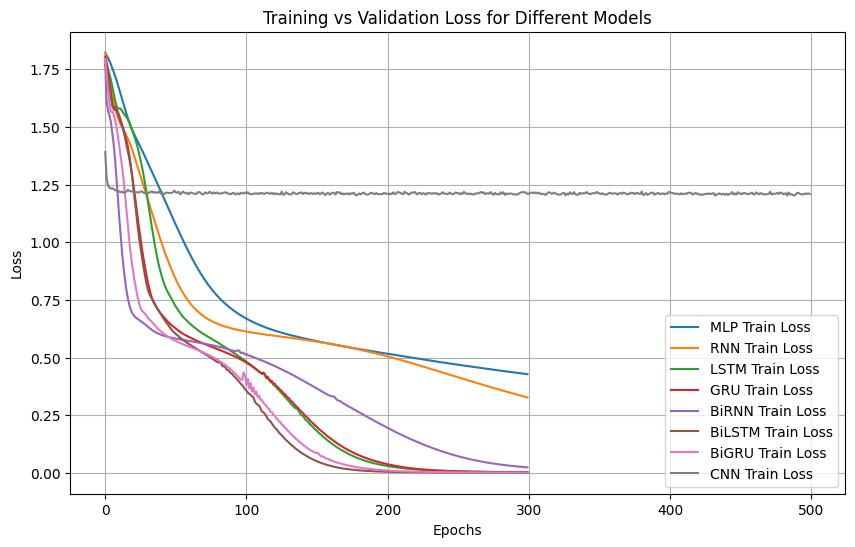

In [44]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10,6))

# loop through models and plot loss curves
for model_name in train_losses.keys():
    plt.plot(train_losses[model_name], label=f"{model_name} Train Loss")

plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training vs Validation Loss for Different Models')
plt.legend()
plt.grid(True)
plt.show()
